# Домашняя работа №3

**Срок сдачи:** 3 декабря 2017, 23:59 <br\>
Штраф за опоздание: -1 балл за каждый день

Файл с дз надо загрузить по [ссылке](https://www.dropbox.com/request/ygtyw9rRFTovCvtJu44k)<br/>
Постарайтесь назвать файл по следующему формату:** [ИАД-*{Номер}*] *{Фамилия}* *{Имя}* ДЗ*{Номер}* **<br/>

Сопровождайте ваш код изображеними, комментариями и выводами. <br/>
Иммейте ввиду, что на некоторые задачи нет единственного верного и полного ответа. Чем больше информации вы сможете извлечь, аргументированных выводов сформулировать, тем лучше.

Используйте данный Ipython Notebook при оформлении домашнего задания.

# Преамбула

Автоэнкодеры - это полносвязные сети, задачей которых является на выходе сети восстановить объекты, поданные на вход. Такие сети состоят из двух частей - енкодера и декодера. В каждом следующем слое энкодера становится всё меньше и меньше нейронов, в результате чего происходит "сжатие" исходной информации. В самом сжатом виде информация находится на последнем слое энкодера который называется bottleneck(с англ. бутылочное горлышко). Далее информация из bottleneck'a подаётся на вход декодеру, у которого наоборот с каждый следующим слоем количество нейронов становится больше и больше. Размерности выходов и входов такой нейронной сети совпадают. 

<img src="https://cdn-images-1.medium.com/max/1600/1*HIBRgSV2ePFtCSOF_lgPCQ.png">

Активации нейронов с самого узкого слоя можно использовать как довольно качественные признаки для передачи в другие модели машинного обучения.

Целью данного домашнего задания является реализация нескольких вариантов автокодировщиков, проведение экспериментов с целью определения структур, которые выучивают нейроны. 

In [2]:
import numpy
import theano
import keras
import pandas as pd
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense, Flatten, Reshape
from keras.models import Model
from keras.models import Sequential
from keras import backend as K
import matplotlib.pyplot as plt
%matplotlib inline

Using Theano backend.


In [315]:
random.seed(33)

# Загрузка и предобработка данных(2.5 балла).

Загрузите *images.npy*. Данный файл содержит набор фото. 

In [5]:
images = np.load(open('images.npy', 'br'))

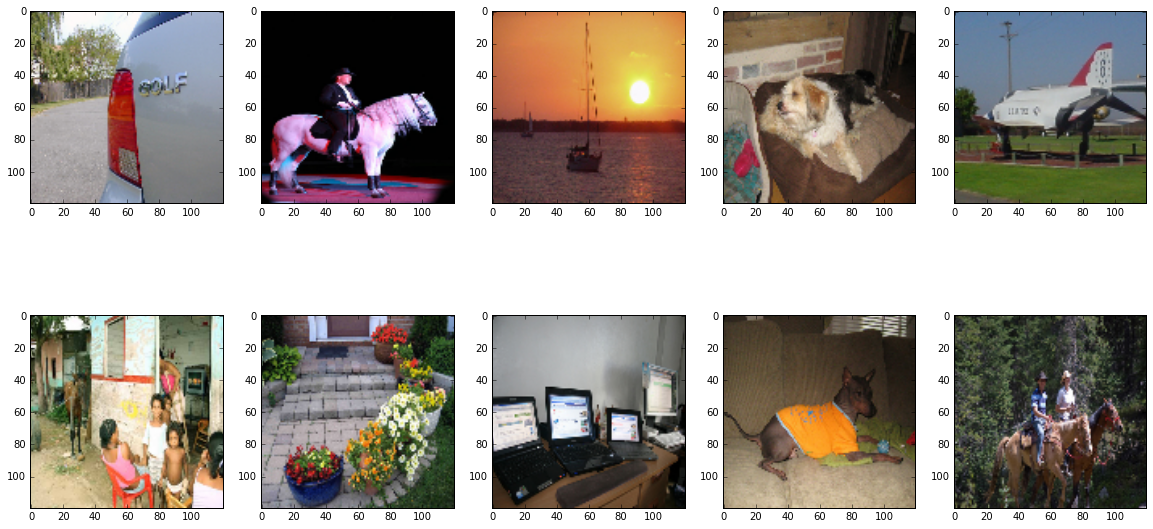

In [6]:
plt.figure(figsize=(20, 10))

for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])

## Генерация датасета(2 балла)

Напишите функцию, которая принимает на вход исходный набор фотографий из возращает нужное количество "сэмплов" - случайных квадратных подкартинок нужного размера. Визуализируйте несколько сэмплов.

In [683]:
def get_samples(full_images, num_samples=10000, sample_size=16):
    samples = np.empty([num_samples, sample_size, sample_size, 3])
    for k in range(num_samples):
        i = random.randint(0, full_images.shape[0] - 1)
        n = random.randint(0, full_images.shape[1] - sample_size)
        l = random.randint(0, full_images.shape[1] - sample_size)
        sample = full_images[i][n:n + sample_size, l:l + sample_size]
        samples[k] = sample
        k += 1
    return samples

Сначала случайным образом выбираем номер картинки, потом ординату и обсциссу пикселя, с которого начнем резать. Записываем весь срез в массив.

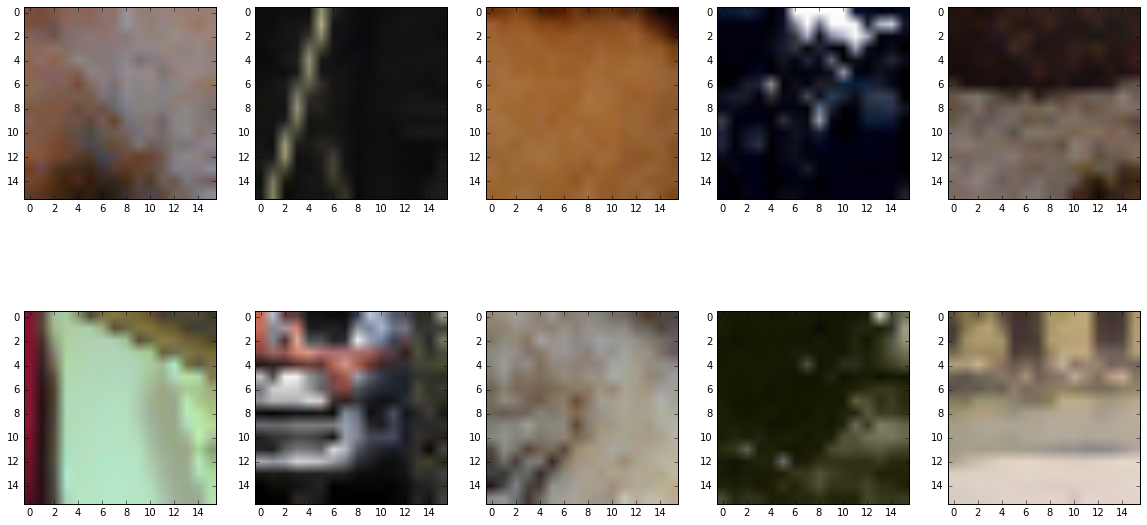

In [776]:
samples_1 = get_samples(images, num_samples=10)

plt.figure(figsize=(20, 10))

for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(samples_1[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

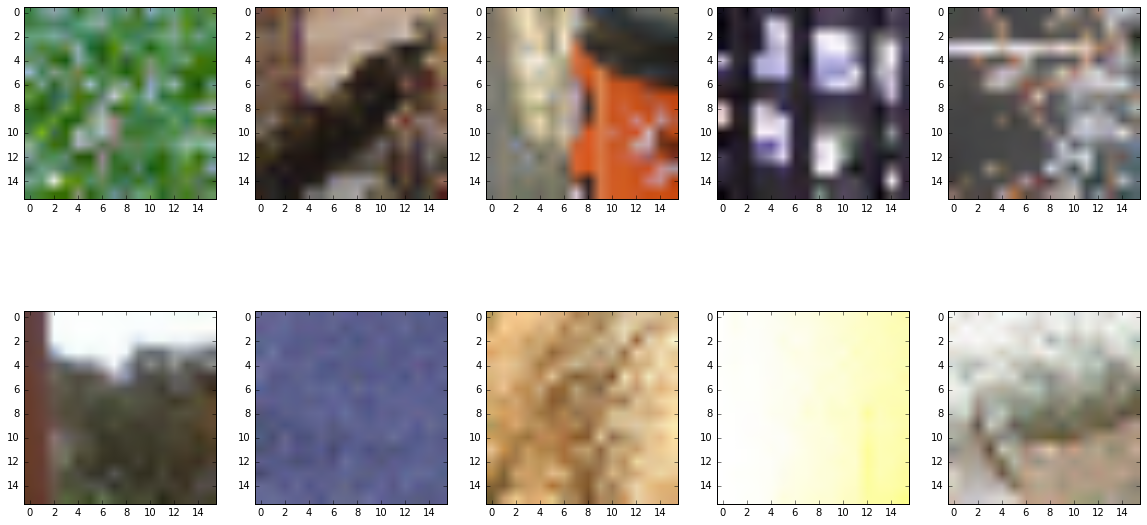

In [777]:
samples_2 = get_samples(images, num_samples=10)

plt.figure(figsize=(20, 10))

for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(samples_2[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

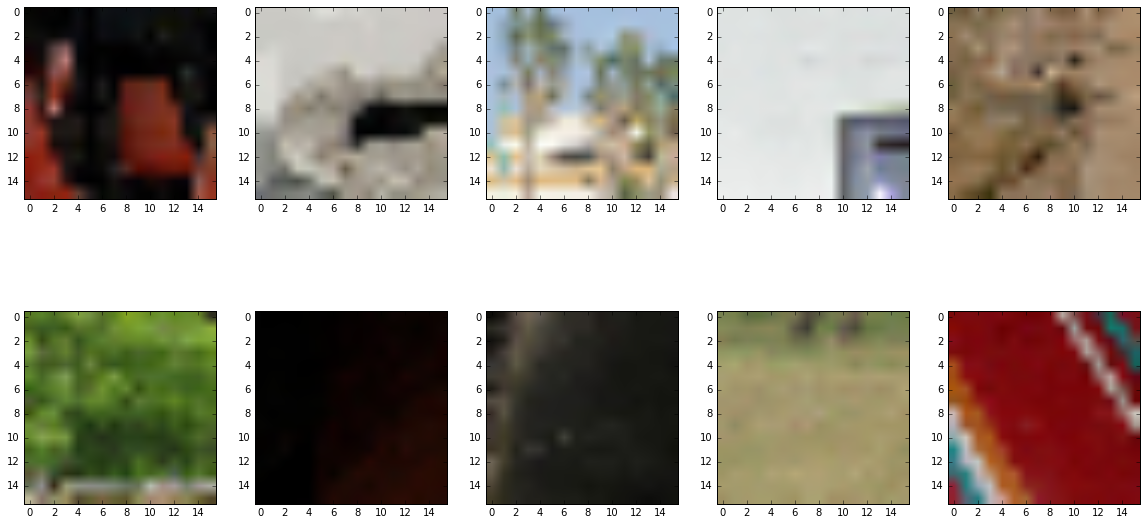

In [778]:
samples_3 = get_samples(images, num_samples=10, sample_size=16)

plt.figure(figsize=(20, 10))

for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(samples_3[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

## Нормировка картинок и вытягивание их в один вектор(0.5 балл)

Переведите интенсивности каждого канала (R, G, B) в отрезок $[0.1, 0.9]$. Значения отбрасывать не надо, просто отшкалируйте каналы.

In [12]:
images_reshaped = images.reshape(7000, 120*120*3)

In [13]:
scaler = MinMaxScaler(feature_range=(0.1, 0.9))

In [14]:
images_scaled = scaler.fit_transform(images_reshaped)

Я сначала вытянула картинки, а потом отшкалировала - MinMaxSacaler ест только двумерные массивы, а цикл работает слииишком долго.

# Реализация и обучение автокодировщика(4 балла)

### Построение автокодировщика(1.5 балла)

Напишите функцию, которая принимает параметры автокодировщика(размер входа и выхода, количества нейронов в каждом слое энкодера, количество нейронов в каждом слое декодера). Внутри автокодировщика использовать нелинейности-RELU. Но для выходов автоэнкодера использовать сигмоиду.

Выход функции - Keras модель, скомпилированная чтобы минимизировать MSE на трэйне. Оптимизатор - на ваш выбор.

In [783]:
def create_autoencoder_model(object_size=768, encoder_layer_shapes=[256, 144, 64], decoder_layer_shapes=[200, 400]):
    input_img = Input(shape=(object_size,))
    x1 = Dense(encoder_layer_shapes[0], activation='relu')(input_img)
    x2 = Dense(encoder_layer_shapes[1], activation='relu')(x1)
    encoded = Dense(encoder_layer_shapes[2], activation='relu')(x2)
    # это энкодер...
                
    x3 = Dense(decoder_layer_shapes[0], activation='relu')(encoded)
    x4 = Dense(decoder_layer_shapes[1], activation='relu')(x3)
    decoded = Dense(object_size, activation='sigmoid')(x4)
    # а это декодер!
                   
    autoencoder = Model(input_img, decoded)
                
    return autoencoder

In [784]:
autoencoder = create_autoencoder_model()

In [785]:
autoencoder.compile(optimizer='adam', loss='mse')

Разделите выборку из сэмплов на тренировочную выборку и валидационную отношении 90%-10%.

In [779]:
data = get_samples(images_scaled.reshape(7000, 120, 120, 3), num_samples=10000, sample_size=16, rand_seed=123)

In [780]:
data = data.reshape(10000, 16*16*3)

In [781]:
X_train, X_test = data[:900], data[-100:]

In [786]:
autoencoder.fit(X_train, X_train,
                  epochs=100,
                  batch_size=256,
                  shuffle=True,
                  validation_data=(X_test, X_test))

Train on 900 samples, validate on 100 samples
Epoch 1/100
900/900 [==============================] - 0s - loss: 0.0513 - val_loss: 0.0494
Epoch 2/100
900/900 [==============================] - 0s - loss: 0.0508 - val_loss: 0.0486
Epoch 3/100
900/900 [==============================] - 0s - loss: 0.0496 - val_loss: 0.0467
Epoch 4/100
900/900 [==============================] - 0s - loss: 0.0469 - val_loss: 0.0440
Epoch 5/100
900/900 [==============================] - 0s - loss: 0.0427 - val_loss: 0.0395
Epoch 6/100
900/900 [==============================] - 0s - loss: 0.0395 - val_loss: 0.0397
Epoch 7/100
900/900 [==============================] - 0s - loss: 0.0367 - val_loss: 0.0337
Epoch 8/100
900/900 [==============================] - 0s - loss: 0.0322 - val_loss: 0.0310
Epoch 9/100
900/900 [==============================] - 0s - loss: 0.0290 - val_loss: 0.0317
Epoch 10/100
900/900 [==============================] - 0s - loss: 0.0297 - val_loss: 0.0305
Epoch 11/100
900/900 [===========

900/900 [==============================] - 0s - loss: 0.0085 - val_loss: 0.0095
Epoch 89/100
900/900 [==============================] - 0s - loss: 0.0084 - val_loss: 0.0095
Epoch 90/100
900/900 [==============================] - 0s - loss: 0.0083 - val_loss: 0.0095
Epoch 91/100
900/900 [==============================] - 0s - loss: 0.0083 - val_loss: 0.0095
Epoch 92/100
900/900 [==============================] - 0s - loss: 0.0083 - val_loss: 0.0095
Epoch 93/100
900/900 [==============================] - 0s - loss: 0.0083 - val_loss: 0.0096
Epoch 94/100
900/900 [==============================] - 0s - loss: 0.0083 - val_loss: 0.0101
Epoch 95/100
900/900 [==============================] - 0s - loss: 0.0095 - val_loss: 0.0097
Epoch 96/100
900/900 [==============================] - 0s - loss: 0.0088 - val_loss: 0.0096
Epoch 97/100
900/900 [==============================] - 0s - loss: 0.0086 - val_loss: 0.0095
Epoch 98/100
900/900 [==============================] - 0s - loss: 0.0085 - val_los

Обучите модель со стандартными параметрами.

### Визуализация паттернов, которые находят нейроны(1.5 балла)

Возьмите несколько объектов из валидационной выборки и прогоните через автоэнкодер. Оцените визуально результат восстановления объектов.

In [790]:
img_test = X_test[:10]

In [791]:
img_hat = autoencoder.predict(img_test)

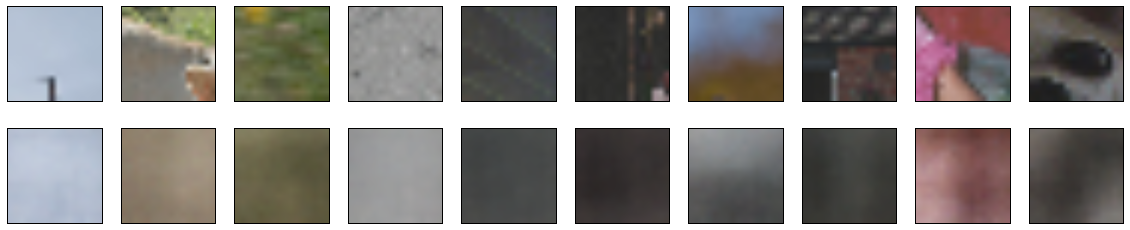

In [792]:
n=10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(img_test[i].reshape(16, 16, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(img_hat[i].reshape(16, 16, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Выглядит неплохо! Схожие черты разичимы, цвет передается, но что-либо понять довольно трудно :с

Для каждого слоя и для каждого нейрона на этом слое найдите объект из тренировочной выборки, на котором этот нейрон выдаёт наибольшую активацию. Если нейрон ни на одном объекте не активировался, пропустите изображение для него. Что можете сказать про сложность шаблонов на объектах для каждого слоя?

In [526]:
def see_image_with_max_activation(w):
    get_layer_output = K.function([autoencoder.layers[0].input],
                                  [autoencoder.layers[w].output])
    a = pd.DataFrame(get_layer_output([X_train])[0])
    shape = [256, 144, 64, 200, 400, 768]
    b = np.zeros((shape[w-1],2))
    for i in range(shape[w-1]):
        b[i][0] = a[i].idxmax()
        b[i][1] = a[i].max()
    c = b[np.argsort(b[:,1])][-10:][::-1, 0:1]
    d = []
    for i in c:
        for j in i:
            d.append(int(j))
    return d

Знаю, жутчайший крокодил, но оно работает!!!

На семинаре сказали вывести по 10 картинок, которые дают самую большую активацию по всем нейронам на каждом слое.

Вот они:

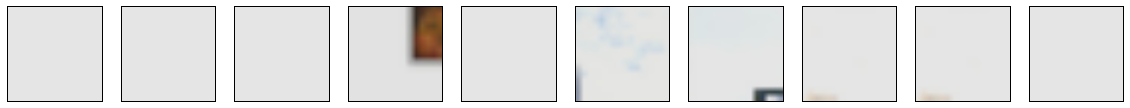

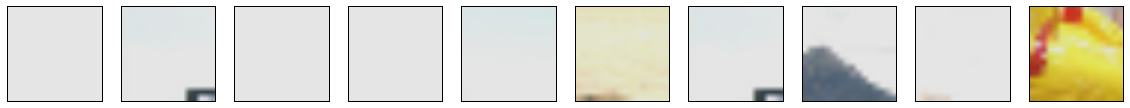

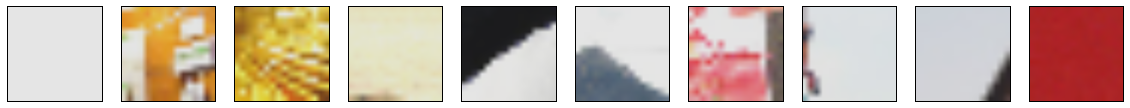

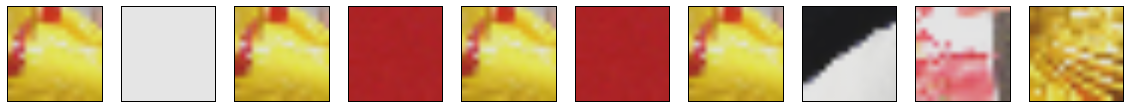

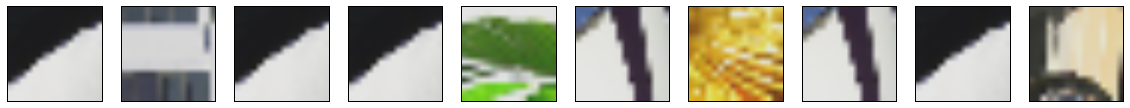

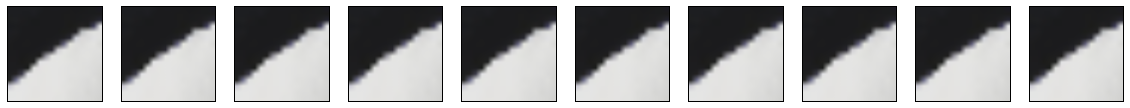

In [796]:
for k in range(1, 7):
    see = see_image_with_max_activation(k)
    n=10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        j = see[i]
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(X_train[j].reshape(16, 16, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.xlabel("Топ 10 картинок, которые дают самую большую активацию по всем нейронам на %i слое" %k)
    plt.show()

### Исследование зависимости качества восстановления от параметров автоэнкодера (1 балл)


Обучите несколько автоэнкодеров с различным количеством слоёв, разными размерами bottleneck'a и сравните, насколько быстро модели обучаются и финальный лосс на валидационной выборке. Какие выводы вы можете сделать?

## Изначально: val_loss = 0.0095

### Сначала оценим, как скорость и лосс зависят от размера  bottleneck'a

In [797]:
auto1 = create_autoencoder_model(encoder_layer_shapes=[256, 144, 5])
auto1.compile(optimizer='adam', loss='mse')
# очень маленькое горлышко

In [798]:
auto1.fit(X_train, X_train,
                  epochs=100,
                  batch_size=256,
                  shuffle=True,
                  validation_data=(X_test, X_test))

Train on 900 samples, validate on 100 samples
Epoch 1/100
900/900 [==============================] - 0s - loss: 0.0512 - val_loss: 0.0494
Epoch 2/100
900/900 [==============================] - 0s - loss: 0.0509 - val_loss: 0.0488
Epoch 3/100
900/900 [==============================] - 0s - loss: 0.0501 - val_loss: 0.0474
Epoch 4/100
900/900 [==============================] - 0s - loss: 0.0488 - val_loss: 0.0455
Epoch 5/100
900/900 [==============================] - 0s - loss: 0.0466 - val_loss: 0.0437
Epoch 6/100
900/900 [==============================] - 0s - loss: 0.0434 - val_loss: 0.0418
Epoch 7/100
900/900 [==============================] - 0s - loss: 0.0405 - val_loss: 0.0404
Epoch 8/100
900/900 [==============================] - 0s - loss: 0.0391 - val_loss: 0.0456
Epoch 9/100
900/900 [==============================] - 0s - loss: 0.0411 - val_loss: 0.0349
Epoch 10/100
900/900 [==============================] - 0s - loss: 0.0358 - val_loss: 0.0340
Epoch 11/100
900/900 [===========

900/900 [==============================] - 0s - loss: 0.0159 - val_loss: 0.0165
Epoch 89/100
900/900 [==============================] - 0s - loss: 0.0158 - val_loss: 0.0164
Epoch 90/100
900/900 [==============================] - 0s - loss: 0.0158 - val_loss: 0.0163
Epoch 91/100
900/900 [==============================] - 0s - loss: 0.0159 - val_loss: 0.0164
Epoch 92/100
900/900 [==============================] - 0s - loss: 0.0158 - val_loss: 0.0164
Epoch 93/100
900/900 [==============================] - 0s - loss: 0.0158 - val_loss: 0.0164
Epoch 94/100
900/900 [==============================] - 0s - loss: 0.0158 - val_loss: 0.0164
Epoch 95/100
900/900 [==============================] - 0s - loss: 0.0158 - val_loss: 0.0165
Epoch 96/100
900/900 [==============================] - 0s - loss: 0.0159 - val_loss: 0.0164
Epoch 97/100
900/900 [==============================] - 0s - loss: 0.0158 - val_loss: 0.0163
Epoch 98/100
900/900 [==============================] - 0s - loss: 0.0158 - val_los

In [799]:
auto2 = create_autoencoder_model(encoder_layer_shapes=[256, 144, 30])
auto2.compile(optimizer='adam', loss='mse')
# чуть побольше

In [800]:
auto2.fit(X_train, X_train,
                  epochs=100,
                  batch_size=256,
                  shuffle=True,
                  validation_data=(X_test, X_test))

Train on 900 samples, validate on 100 samples
Epoch 1/100
900/900 [==============================] - 0s - loss: 0.0513 - val_loss: 0.0492
Epoch 2/100
900/900 [==============================] - 0s - loss: 0.0506 - val_loss: 0.0485
Epoch 3/100
900/900 [==============================] - 0s - loss: 0.0492 - val_loss: 0.0455
Epoch 4/100
900/900 [==============================] - 0s - loss: 0.0459 - val_loss: 0.0428
Epoch 5/100
900/900 [==============================] - 0s - loss: 0.0435 - val_loss: 0.0402
Epoch 6/100
900/900 [==============================] - 0s - loss: 0.0414 - val_loss: 0.0363
Epoch 7/100
900/900 [==============================] - 0s - loss: 0.0379 - val_loss: 0.0341
Epoch 8/100
900/900 [==============================] - 0s - loss: 0.0350 - val_loss: 0.0316
Epoch 9/100
900/900 [==============================] - 0s - loss: 0.0316 - val_loss: 0.0287
Epoch 10/100
900/900 [==============================] - 0s - loss: 0.0285 - val_loss: 0.0295
Epoch 11/100
900/900 [===========

900/900 [==============================] - 0s - loss: 0.0098 - val_loss: 0.0109
Epoch 89/100
900/900 [==============================] - 0s - loss: 0.0097 - val_loss: 0.0110
Epoch 90/100
900/900 [==============================] - 0s - loss: 0.0096 - val_loss: 0.0105
Epoch 91/100
900/900 [==============================] - 0s - loss: 0.0094 - val_loss: 0.0104
Epoch 92/100
900/900 [==============================] - 0s - loss: 0.0094 - val_loss: 0.0105
Epoch 93/100
900/900 [==============================] - 0s - loss: 0.0093 - val_loss: 0.0104
Epoch 94/100
900/900 [==============================] - 0s - loss: 0.0092 - val_loss: 0.0103
Epoch 95/100
900/900 [==============================] - 0s - loss: 0.0091 - val_loss: 0.0103
Epoch 96/100
900/900 [==============================] - 0s - loss: 0.0091 - val_loss: 0.0102
Epoch 97/100
900/900 [==============================] - 0s - loss: 0.0092 - val_loss: 0.0106
Epoch 98/100
900/900 [==============================] - 0s - loss: 0.0094 - val_los

In [801]:
auto3 = create_autoencoder_model(encoder_layer_shapes=[256, 144, 100])
auto3.compile(optimizer='adam', loss='mse')
#больше, чем было

In [802]:
auto3.fit(X_train, X_train,
                  epochs=100,
                  batch_size=256,
                  shuffle=True,
                  validation_data=(X_test, X_test))

Train on 900 samples, validate on 100 samples
Epoch 1/100
900/900 [==============================] - 0s - loss: 0.0513 - val_loss: 0.0492
Epoch 2/100
900/900 [==============================] - 0s - loss: 0.0507 - val_loss: 0.0483
Epoch 3/100
900/900 [==============================] - 0s - loss: 0.0494 - val_loss: 0.0459
Epoch 4/100
900/900 [==============================] - 0s - loss: 0.0465 - val_loss: 0.0434
Epoch 5/100
900/900 [==============================] - 0s - loss: 0.0433 - val_loss: 0.0381
Epoch 6/100
900/900 [==============================] - 0s - loss: 0.0378 - val_loss: 0.0342
Epoch 7/100
900/900 [==============================] - 0s - loss: 0.0385 - val_loss: 0.0326
Epoch 8/100
900/900 [==============================] - 0s - loss: 0.0361 - val_loss: 0.0346
Epoch 9/100
900/900 [==============================] - 0s - loss: 0.0332 - val_loss: 0.0313
Epoch 10/100
900/900 [==============================] - 0s - loss: 0.0318 - val_loss: 0.0272
Epoch 11/100
900/900 [===========

900/900 [==============================] - 0s - loss: 0.0083 - val_loss: 0.0096
Epoch 89/100
900/900 [==============================] - 0s - loss: 0.0082 - val_loss: 0.0095
Epoch 90/100
900/900 [==============================] - 0s - loss: 0.0082 - val_loss: 0.0096
Epoch 91/100
900/900 [==============================] - 0s - loss: 0.0081 - val_loss: 0.0095
Epoch 92/100
900/900 [==============================] - 0s - loss: 0.0081 - val_loss: 0.0094
Epoch 93/100
900/900 [==============================] - 0s - loss: 0.0081 - val_loss: 0.0094
Epoch 94/100
900/900 [==============================] - 0s - loss: 0.0080 - val_loss: 0.0094
Epoch 95/100
900/900 [==============================] - 0s - loss: 0.0080 - val_loss: 0.0093
Epoch 96/100
900/900 [==============================] - 0s - loss: 0.0080 - val_loss: 0.0094
Epoch 97/100
900/900 [==============================] - 0s - loss: 0.0079 - val_loss: 0.0093
Epoch 98/100
900/900 [==============================] - 0s - loss: 0.0080 - val_los

Все нейронки учатся очень быстро, с увеличнием количества параметров время увеличивается, но совсем чуть-чуть.

Чем больше размер bottleneck'a, тем меньше потери на валидации.

### А теперь посмотрим, как на лосс и скорость влияет количество слоев.

In [803]:
def create_autoencoder_model_4(object_size=768, encoder_layer_shapes=[256, 64], decoder_layer_shapes=[200, 400]):
    input_img = Input(shape=(object_size,))
    x = Dense(encoder_layer_shapes[0], activation='relu')(input_img)
    encoded = Dense(encoder_layer_shapes[1], activation='relu')(x)
    # это энкодер...
                
    x = Dense(decoder_layer_shapes[0], activation='relu')(encoded)
    x = Dense(decoder_layer_shapes[1], activation='relu')(x)
    decoded = Dense(object_size, activation='sigmoid')(x)
    # а это декодер!
                   
    autoencoder = Model(input_img, decoded)
                
    return autoencoder

In [804]:
auto4 = create_autoencoder_model_4()
auto4.compile(optimizer='adam', loss='mse')
#здесь на слой меньше в энкодкре

In [805]:
auto4.fit(X_train, X_train,
                  epochs=100,
                  batch_size=256,
                  shuffle=True,
                  validation_data=(X_test, X_test))

Train on 900 samples, validate on 100 samples
Epoch 1/100
900/900 [==============================] - 0s - loss: 0.0516 - val_loss: 0.0494
Epoch 2/100
900/900 [==============================] - 0s - loss: 0.0508 - val_loss: 0.0485
Epoch 3/100
900/900 [==============================] - 0s - loss: 0.0497 - val_loss: 0.0469
Epoch 4/100
900/900 [==============================] - 0s - loss: 0.0474 - val_loss: 0.0435
Epoch 5/100
900/900 [==============================] - 0s - loss: 0.0438 - val_loss: 0.0409
Epoch 6/100
900/900 [==============================] - 0s - loss: 0.0424 - val_loss: 0.0434
Epoch 7/100
900/900 [==============================] - 0s - loss: 0.0415 - val_loss: 0.0379
Epoch 8/100
900/900 [==============================] - 0s - loss: 0.0385 - val_loss: 0.0365
Epoch 9/100
900/900 [==============================] - 0s - loss: 0.0358 - val_loss: 0.0331
Epoch 10/100
900/900 [==============================] - 0s - loss: 0.0329 - val_loss: 0.0309
Epoch 11/100
900/900 [===========

900/900 [==============================] - 0s - loss: 0.0083 - val_loss: 0.0097
Epoch 89/100
900/900 [==============================] - 0s - loss: 0.0083 - val_loss: 0.0095
Epoch 90/100
900/900 [==============================] - 0s - loss: 0.0082 - val_loss: 0.0095
Epoch 91/100
900/900 [==============================] - 0s - loss: 0.0082 - val_loss: 0.0094
Epoch 92/100
900/900 [==============================] - 0s - loss: 0.0081 - val_loss: 0.0094
Epoch 93/100
900/900 [==============================] - 0s - loss: 0.0081 - val_loss: 0.0095
Epoch 94/100
900/900 [==============================] - 0s - loss: 0.0081 - val_loss: 0.0095
Epoch 95/100
900/900 [==============================] - 0s - loss: 0.0081 - val_loss: 0.0094
Epoch 96/100
900/900 [==============================] - 0s - loss: 0.0081 - val_loss: 0.0094
Epoch 97/100
900/900 [==============================] - 0s - loss: 0.0081 - val_loss: 0.0095
Epoch 98/100
900/900 [==============================] - 0s - loss: 0.0082 - val_los

Потери уменьшились по сравнению с исходной сетью!!111!

Срежем еще слой!

In [806]:
def create_autoencoder_model_5(object_size=768, encoder_layer_shapes=[256, 64], decoder_layer_shapes=[400]):
    input_img = Input(shape=(object_size,))
    x = Dense(encoder_layer_shapes[0], activation='relu')(input_img)
    encoded = Dense(encoder_layer_shapes[1], activation='relu')(x)
    # это энкодер...
                
    x = Dense(decoder_layer_shapes[0], activation='relu')(encoded)
    decoded = Dense(object_size, activation='sigmoid')(x)
    # а это декодер!
                   
    autoencoder = Model(input_img, decoded)
                
    return autoencoder

In [807]:
auto5= create_autoencoder_model_5()
auto5.compile(optimizer='adam', loss='mse')
#срезаем еще слой в декодере

In [808]:
auto5.fit(X_train, X_train,
                  epochs=100,
                  batch_size=256,
                  shuffle=True,
                  validation_data=(X_test, X_test))

Train on 900 samples, validate on 100 samples
Epoch 1/100
900/900 [==============================] - 0s - loss: 0.0515 - val_loss: 0.0494
Epoch 2/100
900/900 [==============================] - 0s - loss: 0.0508 - val_loss: 0.0487
Epoch 3/100
900/900 [==============================] - 0s - loss: 0.0500 - val_loss: 0.0476
Epoch 4/100
900/900 [==============================] - 0s - loss: 0.0486 - val_loss: 0.0459
Epoch 5/100
900/900 [==============================] - 0s - loss: 0.0463 - val_loss: 0.0429
Epoch 6/100
900/900 [==============================] - 0s - loss: 0.0428 - val_loss: 0.0391
Epoch 7/100
900/900 [==============================] - 0s - loss: 0.0392 - val_loss: 0.0367
Epoch 8/100
900/900 [==============================] - 0s - loss: 0.0366 - val_loss: 0.0343
Epoch 9/100
900/900 [==============================] - 0s - loss: 0.0337 - val_loss: 0.0313
Epoch 10/100
900/900 [==============================] - 0s - loss: 0.0329 - val_loss: 0.0304
Epoch 11/100
900/900 [===========

900/900 [==============================] - 0s - loss: 0.0084 - val_loss: 0.0096
Epoch 89/100
900/900 [==============================] - 0s - loss: 0.0083 - val_loss: 0.0096
Epoch 90/100
900/900 [==============================] - 0s - loss: 0.0082 - val_loss: 0.0098
Epoch 91/100
900/900 [==============================] - 0s - loss: 0.0084 - val_loss: 0.0097
Epoch 92/100
900/900 [==============================] - 0s - loss: 0.0083 - val_loss: 0.0095
Epoch 93/100
900/900 [==============================] - 0s - loss: 0.0085 - val_loss: 0.0096
Epoch 94/100
900/900 [==============================] - 0s - loss: 0.0082 - val_loss: 0.0096
Epoch 95/100
900/900 [==============================] - 0s - loss: 0.0082 - val_loss: 0.0094
Epoch 96/100
900/900 [==============================] - 0s - loss: 0.0081 - val_loss: 0.0095
Epoch 97/100
900/900 [==============================] - 0s - loss: 0.0082 - val_loss: 0.0094
Epoch 98/100
900/900 [==============================] - 0s - loss: 0.0080 - val_los

Потери меньше, чем в самой первой, но на чуть-чуть.

In [809]:
def create_autoencoder_model_6(object_size=768, encoder_layer_shapes=[64], decoder_layer_shapes=[400]):
    input_img = Input(shape=(object_size,))
    encoded = Dense(encoder_layer_shapes[0], activation='relu')(input_img)
    # это энкодер...
                
    x = Dense(decoder_layer_shapes[0], activation='relu')(encoded)
    decoded = Dense(object_size, activation='sigmoid')(x)
    # а это декодер!
                   
    autoencoder = Model(input_img, decoded)
                
    return autoencoder

In [810]:
auto6= create_autoencoder_model_6()
auto6.compile(optimizer='adam', loss='mse')
#еще на 1 слой меньше в энкодере

In [811]:
auto6.fit(X_train, X_train,
                  epochs=100,
                  batch_size=256,
                  shuffle=True,
                  validation_data=(X_test, X_test))

Train on 900 samples, validate on 100 samples
Epoch 1/100
900/900 [==============================] - 0s - loss: 0.0515 - val_loss: 0.0493
Epoch 2/100
900/900 [==============================] - 0s - loss: 0.0507 - val_loss: 0.0485
Epoch 3/100
900/900 [==============================] - 0s - loss: 0.0499 - val_loss: 0.0473
Epoch 4/100
900/900 [==============================] - 0s - loss: 0.0487 - val_loss: 0.0456
Epoch 5/100
900/900 [==============================] - 0s - loss: 0.0468 - val_loss: 0.0435
Epoch 6/100
900/900 [==============================] - 0s - loss: 0.0445 - val_loss: 0.0412
Epoch 7/100
900/900 [==============================] - 0s - loss: 0.0416 - val_loss: 0.0377
Epoch 8/100
900/900 [==============================] - 0s - loss: 0.0380 - val_loss: 0.0347
Epoch 9/100
900/900 [==============================] - 0s - loss: 0.0347 - val_loss: 0.0330
Epoch 10/100
900/900 [==============================] - 0s - loss: 0.0330 - val_loss: 0.0306
Epoch 11/100
900/900 [===========

900/900 [==============================] - 0s - loss: 0.0075 - val_loss: 0.0083
Epoch 89/100
900/900 [==============================] - 0s - loss: 0.0072 - val_loss: 0.0083
Epoch 90/100
900/900 [==============================] - 0s - loss: 0.0072 - val_loss: 0.0083
Epoch 91/100
900/900 [==============================] - 0s - loss: 0.0071 - val_loss: 0.0082
Epoch 92/100
900/900 [==============================] - 0s - loss: 0.0071 - val_loss: 0.0083
Epoch 93/100
900/900 [==============================] - 0s - loss: 0.0070 - val_loss: 0.0082
Epoch 94/100
900/900 [==============================] - 0s - loss: 0.0070 - val_loss: 0.0081
Epoch 95/100
900/900 [==============================] - 0s - loss: 0.0070 - val_loss: 0.0084
Epoch 96/100
900/900 [==============================] - 0s - loss: 0.0071 - val_loss: 0.0082
Epoch 97/100
900/900 [==============================] - 0s - loss: 0.0072 - val_loss: 0.0083
Epoch 98/100
900/900 [==============================] - 0s - loss: 0.0071 - val_los

val_loss еще ниже, чем изначально. Волшебно!

Попробуем увеличить колличество слоев:

In [812]:
def create_autoencoder_model_7(object_size=768, encoder_layer_shapes=[256, 144, 100, 64], 
                               decoder_layer_shapes=[200, 400]):
    input_img = Input(shape=(object_size,))
    x = Dense(encoder_layer_shapes[0], activation='relu')(input_img)
    x = Dense(encoder_layer_shapes[1], activation='relu')(x)
    x = Dense(encoder_layer_shapes[2], activation='relu')(x)
    
    encoded = Dense(encoder_layer_shapes[3], activation='relu')(x)
    # это энкодер...
                
    x = Dense(decoder_layer_shapes[0], activation='relu')(encoded)
    x = Dense(decoder_layer_shapes[1], activation='relu')(x)
    decoded = Dense(object_size, activation='sigmoid')(x)
    # а это декодер!
                   
    autoencoder = Model(input_img, decoded)
                
    return autoencoder

In [813]:
auto7 = create_autoencoder_model_7()
auto7.compile(optimizer='adam', loss='mse')
#добавим слой в энкодер

In [814]:
auto7.fit(X_train, X_train,
                  epochs=100,
                  batch_size=256,
                  shuffle=True,
                  validation_data=(X_test, X_test))

Train on 900 samples, validate on 100 samples
Epoch 1/100
900/900 [==============================] - 0s - loss: 0.0513 - val_loss: 0.0494
Epoch 2/100
900/900 [==============================] - 0s - loss: 0.0508 - val_loss: 0.0487
Epoch 3/100
900/900 [==============================] - 0s - loss: 0.0497 - val_loss: 0.0474
Epoch 4/100
900/900 [==============================] - 0s - loss: 0.0476 - val_loss: 0.0436
Epoch 5/100
900/900 [==============================] - 0s - loss: 0.0451 - val_loss: 0.0397
Epoch 6/100
900/900 [==============================] - 0s - loss: 0.0414 - val_loss: 0.0366
Epoch 7/100
900/900 [==============================] - 0s - loss: 0.0382 - val_loss: 0.0340
Epoch 8/100
900/900 [==============================] - 0s - loss: 0.0340 - val_loss: 0.0308
Epoch 9/100
900/900 [==============================] - 0s - loss: 0.0359 - val_loss: 0.0304
Epoch 10/100
900/900 [==============================] - 0s - loss: 0.0306 - val_loss: 0.0291
Epoch 11/100
900/900 [===========

900/900 [==============================] - 0s - loss: 0.0095 - val_loss: 0.0110
Epoch 89/100
900/900 [==============================] - 0s - loss: 0.0096 - val_loss: 0.0108
Epoch 90/100
900/900 [==============================] - 0s - loss: 0.0094 - val_loss: 0.0109
Epoch 91/100
900/900 [==============================] - 0s - loss: 0.0095 - val_loss: 0.0108
Epoch 92/100
900/900 [==============================] - 0s - loss: 0.0095 - val_loss: 0.0107
Epoch 93/100
900/900 [==============================] - 0s - loss: 0.0093 - val_loss: 0.0107
Epoch 94/100
900/900 [==============================] - 0s - loss: 0.0092 - val_loss: 0.0107
Epoch 95/100
900/900 [==============================] - 0s - loss: 0.0092 - val_loss: 0.0107
Epoch 96/100
900/900 [==============================] - 0s - loss: 0.0095 - val_loss: 0.0111
Epoch 97/100
900/900 [==============================] - 0s - loss: 0.0094 - val_loss: 0.0107
Epoch 98/100
900/900 [==============================] - 0s - loss: 0.0093 - val_los

Потери увеличились :с

In [815]:
def create_autoencoder_model_7(object_size=768, encoder_layer_shapes=[256, 144, 100, 80, 64], 
                               decoder_layer_shapes=[200, 400]):
    input_img = Input(shape=(object_size,))
    x = Dense(encoder_layer_shapes[0], activation='relu')(input_img)
    x = Dense(encoder_layer_shapes[1], activation='relu')(x)
    x = Dense(encoder_layer_shapes[2], activation='relu')(x)
    x = Dense(encoder_layer_shapes[3], activation='relu')(x)
    encoded = Dense(encoder_layer_shapes[4], activation='relu')(x)
    # это энкодер...
                
    x = Dense(decoder_layer_shapes[0], activation='relu')(encoded)
    x = Dense(decoder_layer_shapes[1], activation='relu')(x)
    decoded = Dense(object_size, activation='sigmoid')(x)
    # а это декодер!
                   
    autoencoder = Model(input_img, decoded)
                
    return autoencoder

In [816]:
auto8 = create_autoencoder_model_8()
auto8.compile(optimizer='adam', loss='mse')
# больше слоев в энкодер!

In [817]:
auto8.fit(X_train, X_train,
                  epochs=100,
                  batch_size=256,
                  shuffle=True,
                  validation_data=(X_test, X_test))

Train on 900 samples, validate on 100 samples
Epoch 1/100
900/900 [==============================] - 0s - loss: 0.0512 - val_loss: 0.0491
Epoch 2/100
900/900 [==============================] - 0s - loss: 0.0505 - val_loss: 0.0476
Epoch 3/100
900/900 [==============================] - 0s - loss: 0.0486 - val_loss: 0.0460
Epoch 4/100
900/900 [==============================] - 0s - loss: 0.0457 - val_loss: 0.0411
Epoch 5/100
900/900 [==============================] - 0s - loss: 0.0415 - val_loss: 0.0377
Epoch 6/100
900/900 [==============================] - 0s - loss: 0.0370 - val_loss: 0.0332
Epoch 7/100
900/900 [==============================] - 0s - loss: 0.0335 - val_loss: 0.0282
Epoch 8/100
900/900 [==============================] - 0s - loss: 0.0318 - val_loss: 0.0262
Epoch 9/100
900/900 [==============================] - 0s - loss: 0.0296 - val_loss: 0.0278
Epoch 10/100
900/900 [==============================] - 0s - loss: 0.0266 - val_loss: 0.0267
Epoch 11/100
900/900 [===========

900/900 [==============================] - 0s - loss: 0.0098 - val_loss: 0.0113
Epoch 89/100
900/900 [==============================] - 0s - loss: 0.0098 - val_loss: 0.0114
Epoch 90/100
900/900 [==============================] - 0s - loss: 0.0097 - val_loss: 0.0112
Epoch 91/100
900/900 [==============================] - 0s - loss: 0.0097 - val_loss: 0.0112
Epoch 92/100
900/900 [==============================] - 0s - loss: 0.0097 - val_loss: 0.0112
Epoch 93/100
900/900 [==============================] - 0s - loss: 0.0097 - val_loss: 0.0114
Epoch 94/100
900/900 [==============================] - 0s - loss: 0.0102 - val_loss: 0.0112
Epoch 95/100
900/900 [==============================] - 0s - loss: 0.0099 - val_loss: 0.0114
Epoch 96/100
900/900 [==============================] - 0s - loss: 0.0097 - val_loss: 0.0111
Epoch 97/100
900/900 [==============================] - 0s - loss: 0.0097 - val_loss: 0.0111
Epoch 98/100
900/900 [==============================] - 0s - loss: 0.0095 - val_los

При увеличении количества слоев энкодера потери увеличиваются.

Тепеоь увеличим количество слоев у декодера.

In [818]:
def create_autoencoder_model_8(object_size=768, encoder_layer_shapes=[256, 144, 64], decoder_layer_shapes=[200, 400,
                                                                                                           600]):
    input_img = Input(shape=(object_size,))
    x = Dense(encoder_layer_shapes[0], activation='relu')(input_img)
    x = Dense(encoder_layer_shapes[1], activation='relu')(x)
    
    encoded = Dense(encoder_layer_shapes[2], activation='relu')(x)
    # это энкодер...
                
    x = Dense(decoder_layer_shapes[0], activation='relu')(encoded)
    x = Dense(decoder_layer_shapes[1], activation='relu')(x)
    x = Dense(decoder_layer_shapes[2], activation='relu')(x)
    decoded = Dense(object_size, activation='sigmoid')(x)
    # а это декодер!
                   
    autoencoder = Model(input_img, decoded)
                
    return autoencoder

In [819]:
auto8 = create_autoencoder_model_8()
auto8.compile(optimizer='adam', loss='mse')
#плюс слой в декодер

In [820]:
auto8.fit(X_train, X_train,
                  epochs=100,
                  batch_size=256,
                  shuffle=True,
                  validation_data=(X_test, X_test))

Train on 900 samples, validate on 100 samples
Epoch 1/100
900/900 [==============================] - 0s - loss: 0.0512 - val_loss: 0.0491
Epoch 2/100
900/900 [==============================] - 0s - loss: 0.0504 - val_loss: 0.0478
Epoch 3/100
900/900 [==============================] - 0s - loss: 0.0485 - val_loss: 0.0441
Epoch 4/100
900/900 [==============================] - 0s - loss: 0.0434 - val_loss: 0.0392
Epoch 5/100
900/900 [==============================] - 0s - loss: 0.0451 - val_loss: 0.0435
Epoch 6/100
900/900 [==============================] - 0s - loss: 0.0410 - val_loss: 0.0356
Epoch 7/100
900/900 [==============================] - 0s - loss: 0.0360 - val_loss: 0.0358
Epoch 8/100
900/900 [==============================] - 0s - loss: 0.0340 - val_loss: 0.0337
Epoch 9/100
900/900 [==============================] - 0s - loss: 0.0318 - val_loss: 0.0303
Epoch 10/100
900/900 [==============================] - 0s - loss: 0.0278 - val_loss: 0.0249
Epoch 11/100
900/900 [===========

900/900 [==============================] - 0s - loss: 0.0086 - val_loss: 0.0102
Epoch 89/100
900/900 [==============================] - 0s - loss: 0.0085 - val_loss: 0.0102
Epoch 90/100
900/900 [==============================] - 0s - loss: 0.0086 - val_loss: 0.0100
Epoch 91/100
900/900 [==============================] - 0s - loss: 0.0085 - val_loss: 0.0098
Epoch 92/100
900/900 [==============================] - 0s - loss: 0.0085 - val_loss: 0.0098
Epoch 93/100
900/900 [==============================] - 0s - loss: 0.0084 - val_loss: 0.0099
Epoch 94/100
900/900 [==============================] - 0s - loss: 0.0085 - val_loss: 0.0098
Epoch 95/100
900/900 [==============================] - 0s - loss: 0.0085 - val_loss: 0.0097
Epoch 96/100
900/900 [==============================] - 0s - loss: 0.0083 - val_loss: 0.0098
Epoch 97/100
900/900 [==============================] - 0s - loss: 0.0082 - val_loss: 0.0097
Epoch 98/100
900/900 [==============================] - 0s - loss: 0.0081 - val_los

Чуть больше, чем было

In [821]:
def create_autoencoder_model_9(object_size=768, encoder_layer_shapes=[256, 144, 64], decoder_layer_shapes=[100, 200,
                                                                                                           400, 600]):
    input_img = Input(shape=(object_size,))
    x = Dense(encoder_layer_shapes[0], activation='relu')(input_img)
    x = Dense(encoder_layer_shapes[1], activation='relu')(x)
    
    encoded = Dense(encoder_layer_shapes[2], activation='relu')(x)
    # это энкодер...
                
    x = Dense(decoder_layer_shapes[0], activation='relu')(encoded)
    x = Dense(decoder_layer_shapes[1], activation='relu')(x)
    x = Dense(decoder_layer_shapes[2], activation='relu')(x)
    x = Dense(decoder_layer_shapes[3], activation='relu')(x)
    decoded = Dense(object_size, activation='sigmoid')(x)
    # а это декодер!
                   
    autoencoder = Model(input_img, decoded)
                
    return autoencoder

In [822]:
auto9 = create_autoencoder_model_9()
auto9.compile(optimizer='adam', loss='mse')
#и еще

In [823]:
auto9.fit(X_train, X_train,
                  epochs=100,
                  batch_size=256,
                  shuffle=True,
                  validation_data=(X_test, X_test))

Train on 900 samples, validate on 100 samples
Epoch 1/100
900/900 [==============================] - 0s - loss: 0.0512 - val_loss: 0.0491
Epoch 2/100
900/900 [==============================] - 0s - loss: 0.0505 - val_loss: 0.0481
Epoch 3/100
900/900 [==============================] - 0s - loss: 0.0487 - val_loss: 0.0449
Epoch 4/100
900/900 [==============================] - 0s - loss: 0.0447 - val_loss: 0.0402
Epoch 5/100
900/900 [==============================] - 0s - loss: 0.0431 - val_loss: 0.0397
Epoch 6/100
900/900 [==============================] - 0s - loss: 0.0398 - val_loss: 0.0499
Epoch 7/100
900/900 [==============================] - 0s - loss: 0.0422 - val_loss: 0.0363
Epoch 8/100
900/900 [==============================] - 0s - loss: 0.0349 - val_loss: 0.0318
Epoch 9/100
900/900 [==============================] - 0s - loss: 0.0303 - val_loss: 0.0274
Epoch 10/100
900/900 [==============================] - 0s - loss: 0.0259 - val_loss: 0.0223
Epoch 11/100
900/900 [===========

900/900 [==============================] - 0s - loss: 0.0099 - val_loss: 0.0112
Epoch 89/100
900/900 [==============================] - 0s - loss: 0.0098 - val_loss: 0.0112
Epoch 90/100
900/900 [==============================] - 0s - loss: 0.0098 - val_loss: 0.0112
Epoch 91/100
900/900 [==============================] - 0s - loss: 0.0097 - val_loss: 0.0112
Epoch 92/100
900/900 [==============================] - 0s - loss: 0.0097 - val_loss: 0.0111
Epoch 93/100
900/900 [==============================] - 0s - loss: 0.0097 - val_loss: 0.0114
Epoch 94/100
900/900 [==============================] - 0s - loss: 0.0097 - val_loss: 0.0111
Epoch 95/100
900/900 [==============================] - 0s - loss: 0.0096 - val_loss: 0.0111
Epoch 96/100
900/900 [==============================] - 0s - loss: 0.0095 - val_loss: 0.0112
Epoch 97/100
900/900 [==============================] - 0s - loss: 0.0097 - val_loss: 0.0112
Epoch 98/100
900/900 [==============================] - 0s - loss: 0.0094 - val_los

Потери ещеее больше

Посмотрим на модель, где больше и слое энкодера, и декодера

In [824]:
def create_autoencoder_model_10(object_size=768, encoder_layer_shapes=[256, 144, 100, 64], decoder_layer_shapes=[200, 400, 600]):
    input_img = Input(shape=(object_size,))
    x = Dense(encoder_layer_shapes[0], activation='relu')(input_img)
    x = Dense(encoder_layer_shapes[1], activation='relu')(x)
    x = Dense(encoder_layer_shapes[2], activation='relu')(x)
    encoded = Dense(encoder_layer_shapes[3], activation='relu')(x)
    # это энкодер...
                
    x = Dense(decoder_layer_shapes[0], activation='relu')(encoded)
    x = Dense(decoder_layer_shapes[1], activation='relu')(x)
    x = Dense(decoder_layer_shapes[2], activation='relu')(x)
    decoded = Dense(object_size, activation='sigmoid')(x)
    # а это декодер!
                   
    autoencoder = Model(input_img, decoded)
                
    return autoencoder

In [825]:
auto10 = create_autoencoder_model_10()
auto10.compile(optimizer='adam', loss='mse')

In [826]:
auto10.fit(X_train, X_train,
                  epochs=100,
                  batch_size=256,
                  shuffle=True,
                  validation_data=(X_test, X_test))

Train on 900 samples, validate on 100 samples
Epoch 1/100
900/900 [==============================] - 0s - loss: 0.0512 - val_loss: 0.0493
Epoch 2/100
900/900 [==============================] - 0s - loss: 0.0507 - val_loss: 0.0484
Epoch 3/100
900/900 [==============================] - 0s - loss: 0.0490 - val_loss: 0.0456
Epoch 4/100
900/900 [==============================] - 0s - loss: 0.0463 - val_loss: 0.0404
Epoch 5/100
900/900 [==============================] - 0s - loss: 0.0410 - val_loss: 0.0363
Epoch 6/100
900/900 [==============================] - 0s - loss: 0.0356 - val_loss: 0.0377
Epoch 7/100
900/900 [==============================] - 0s - loss: 0.0361 - val_loss: 0.0324
Epoch 8/100
900/900 [==============================] - 0s - loss: 0.0305 - val_loss: 0.0279
Epoch 9/100
900/900 [==============================] - 0s - loss: 0.0268 - val_loss: 0.0272
Epoch 10/100
900/900 [==============================] - 0s - loss: 0.0237 - val_loss: 0.0205
Epoch 11/100
900/900 [===========

900/900 [==============================] - 0s - loss: 0.0099 - val_loss: 0.0112
Epoch 89/100
900/900 [==============================] - 0s - loss: 0.0099 - val_loss: 0.0113
Epoch 90/100
900/900 [==============================] - 0s - loss: 0.0098 - val_loss: 0.0112
Epoch 91/100
900/900 [==============================] - 0s - loss: 0.0098 - val_loss: 0.0112
Epoch 92/100
900/900 [==============================] - 0s - loss: 0.0098 - val_loss: 0.0112
Epoch 93/100
900/900 [==============================] - 0s - loss: 0.0098 - val_loss: 0.0112
Epoch 94/100
900/900 [==============================] - 0s - loss: 0.0098 - val_loss: 0.0111
Epoch 95/100
900/900 [==============================] - 0s - loss: 0.0098 - val_loss: 0.0113
Epoch 96/100
900/900 [==============================] - 0s - loss: 0.0097 - val_loss: 0.0111
Epoch 97/100
900/900 [==============================] - 0s - loss: 0.0097 - val_loss: 0.0111
Epoch 98/100
900/900 [==============================] - 0s - loss: 0.0097 - val_los

Опять потери увеличились :с

С уменьшением колличества слоев потери также уменьшаются. Новые слои все портят.

In [227]:
print("¯\_(ツ)_/¯")

¯\_(ツ)_/¯


# Классификация MNIST и CIFAR (3,5 балла)

### MNIST (2 балла)

Загрузите датасет MNIST и провизуализируйте несколько цифр.

In [238]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test)  = mnist.load_data()

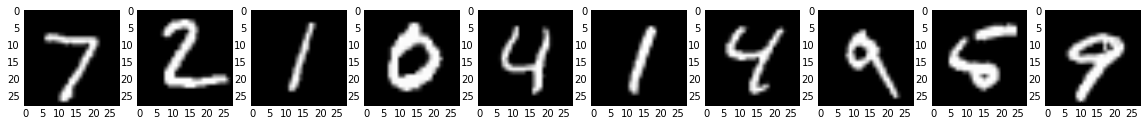

In [357]:
n = 10 
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(x_test[i])
    plt.gray()
plt.show()

Сожмите данные автокодировщиком, у которого только один скрытый слой(по сути только bottleneck) с 30 нейронами.

In [571]:
x_train = x_train.reshape(60000, 28*28)
x_test = x_test.reshape(10000, 28*28)

In [572]:
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

In [644]:
def create_encoder_model(object_size=784, encoder_layer_shapes=30):
    input_img = Input(shape=(object_size,))
    encod = Dense(30, activation='relu')(input_img)
    decod = Dense(object_size, activation='sigmoid')(encod)
    encoder = Model(input_img, encod)
    autoencoder = Model(input_img, decod)
    return encoder, autoencoder

In [645]:
encoder, autoencoder = create_encoder_model()

In [648]:
autoencoder.compile(optimizer='adam', loss="mse")

In [650]:
autoencoder.fit(x_train, x_train, epochs=30, validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 19s - loss: 0.0110 - val_loss: 0.0100
Epoch 2/30
60000/60000 [==============================] - 15s - loss: 0.0102 - val_loss: 0.0098
Epoch 3/30
60000/60000 [==============================] - 20s - loss: 0.0100 - val_loss: 0.0097
Epoch 4/30
60000/60000 [==============================] - 32s - loss: 0.0100 - val_loss: 0.0097
Epoch 5/30
60000/60000 [==============================] - 14s - loss: 0.0100 - val_loss: 0.0097
Epoch 6/30
60000/60000 [==============================] - 9s - loss: 0.0099 - val_loss: 0.0097
Epoch 7/30
60000/60000 [==============================] - 13s - loss: 0.0099 - val_loss: 0.0096
Epoch 8/30
60000/60000 [==============================] - 27s - loss: 0.0099 - val_loss: 0.0096
Epoch 9/30
60000/60000 [==============================] - 32s - loss: 0.0099 - val_loss: 0.0096
Epoch 10/30
60000/60000 [==============================] - 10s - loss: 0.0099 - val_los

In [656]:
x1_train = encoder.predict(x_train)

In [657]:
x1_test = encoder.predict(x_test)

Возьмите несколько моделей из sklearn (KNN,SVM, RandomForest, GradientBoosting/XGBClassifier) и обучите модель со стандартными параметрами на выходах энкодера. Какие у вас получились результаты(точность) на тесте?

In [654]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

In [658]:
knn = KNeighborsClassifier()
knn.fit(x1_train, y_train)
y1_pred = knn.predict(x1_test)
print("Точность", accuracy_score(y_test, y1_pred))

Точность 0.9721


In [659]:
svc = SVC()
svc.fit(x1_train, y_train)
y1_pred = svc.predict(x1_test)

print("Точность", accuracy_score(y_test, y1_pred))

Точность 0.9839


In [660]:
rf = RandomForestClassifier()
rf.fit(x1_train, y_train)
y1_pred = rf.predict(x1_test)
print("Точность", accuracy_score(y_test, y1_pred))

Точность 0.9186


In [662]:
gb = GradientBoostingClassifier()
gb.fit(x1_train, y_train)
y1_pred = gb.predict(x1_test)
print("Точность", accuracy_score(y_test, y1_pred))

Точность 0.9227


Офигенная точность!!! Я сравнивала результаты при обучении на исходных данных и на закодированных, на исходных оно выше всего на чуток (0.02)

### CIFAR10(2 балла)

Загрузите CIFAR10 и обучите автоэнкодер на случайных сэмплах размера 8x8 из этого датасета. Архитектура автоэнкодера как в прошлом пункте - только один внутренний слой из 30 нейронов.

In [680]:
from keras.datasets import cifar10
(xx_train, yy_train), (xx_test, yy_test) = cifar10.load_data()

In [699]:
xx_train.shape

(50000, 32, 32, 3)

In [687]:
non_train = get_samples(xx_train, num_samples=5000, sample_size=8)
non_test = get_samples(xx_test, num_samples=1000, sample_size=8)

In [688]:
non_train = non_train.reshape(5000, 8*8*3)
non_test = non_test.reshape(1000, 8*8*3)

In [689]:
non_train = scaler.fit_transform(non_train)
non_test = scaler.fit_transform(non_test)

In [694]:
encoder, autoencoder = create_encoder_model(object_size=192)

In [696]:
autoencoder.compile(loss = 'mse', optimizer='adam')

In [697]:
autoencoder.fit(non_train, non_train, epochs=30,  validation_data=(non_test, non_test))

Train on 5000 samples, validate on 1000 samples
Epoch 1/30
5000/5000 [==============================] - 0s - loss: 0.0338 - val_loss: 0.0262
Epoch 2/30
5000/5000 [==============================] - 0s - loss: 0.0205 - val_loss: 0.0164
Epoch 3/30
5000/5000 [==============================] - 0s - loss: 0.0138 - val_loss: 0.0113
Epoch 4/30
5000/5000 [==============================] - 0s - loss: 0.0096 - val_loss: 0.0082
Epoch 5/30
5000/5000 [==============================] - 0s - loss: 0.0071 - val_loss: 0.0066
Epoch 6/30
5000/5000 [==============================] - 0s - loss: 0.0057 - val_loss: 0.0055
Epoch 7/30
5000/5000 [==============================] - 0s - loss: 0.0049 - val_loss: 0.0049
Epoch 8/30
5000/5000 [==============================] - 0s - loss: 0.0044 - val_loss: 0.0046
Epoch 9/30
5000/5000 [==============================] - 0s - loss: 0.0042 - val_loss: 0.0043
Epoch 10/30
5000/5000 [==============================] - 0s - loss: 0.0040 - val_loss: 0.0041
Epoch 11/30
5000/5000

Теперь разделите каждую картинку из датасета на 16 сэмплов размера 8x8, закодируйте их через энкодер и склейте 16 выходов энкодера в один вектор. Каждый объект в итоге должен кодироваться 16 * 30 = 380 признаками.

In [702]:
x_samples = np.empty((800000,8, 8, 3))

In [751]:
x_samples = np.empty((800000,8, 8, 3))
l = 0 
for m in range(50000):
    nrr = np.empty((16,8,8,3))
    i = 0
    for j in range(4):
        for k in range(4):
            img = xx_train[m][8*j:8*j+8, 8*k:8*k + 8]
            x_samples[i+16*l] = img
            i+=1
    l+=1

Странный цикл для выполнения странного задания.

In [755]:
x_samples = x_samples.reshape(800000, 8*8*3)

In [757]:
x_samples = scaler.fit_transform(x_samples)

In [760]:
x_hat = encoder.predict(x_samples)

In [763]:
x_lol = x_hat.reshape(50000, -1)

Теперь обучите SVM на преобразованных объектах и выведите точность.

In [769]:
XX_train, XX_test, YY_train, YY_test = train_test_split(x_lol, yy_train)

In [770]:
svc.fit(XX_train, YY_train)
y1_pred = svc.predict(XX_test)

print("Точность", accuracy_score(YY_test, y1_pred))

/Users/tata/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Точность 0.50696


Грусть-печаль, наша модель похожа на угадайку :с

In [827]:
rf.fit(XX_train, YY_train)
y1_pred = rf.predict(XX_test)
print("Точность", accuracy_score(YY_test, y1_pred))

/Users/tata/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


Точность 0.33056
